# Análisis Exploratorio de Datos (EDA): Ventas de Videojuegos (VGChartz 2024)

Este análisis exploratorio utiliza un dataset proporcionado por VGChartz que recopila información de más de 64.000 videojuegos publicados en distintas plataformas. El objetivo principal es:

- Comprender la estructura del dataset.
- Evaluar la calidad de la información (valores nulos, duplicados e incoherencias).
- Realizar un proceso de limpieza de datos.
- Generar visualizaciones básicas que ayuden a interpretar patrones de ventas, géneros, plataformas y puntuaciones.
- Dejar el dataset preparado para futuros análisis más avanzados.

Las columnas provienen del diccionario `vg_data_dictionary.csv`, que describe cada variable. 
Estas son las columnas descritas en el diccionario:

img - URL slug for the box art at vgchartz.com
title - Game title
console - Console the game was released for
genre - Genre of the game
publisher - Publisher of the game
developer - Developer of the game
critic_score - Metacritic score (out of 10)
total_sales - Global sales of copies in millions
na_sales - North American sales of copies in millions
jp_sales - Japanese sales of copies in millions
pal_sales - European & African sales of copies in millions
other_sales - Rest of world sales of copies in millions
release_date - Date the game was released on
last_update - Date the data was last updated



In [18]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de gráficos
plt.style.use("default")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

pd.set_option("display.max_columns", None)

# Ajuste de la ruta para poder importar desde src/
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.Limpieza import limpiar_dataset

# Rutas a los datos y a las figuras
RAW_PATH = "../data/dataset.csv"
CLEAN_PATH = "../data/vgchartz-2024-clean.csv"
FIGURES_DIR = "../reports/figures"

os.makedirs(FIGURES_DIR, exist_ok=True)

RAW_PATH, CLEAN_PATH, FIGURES_DIR


('../data/dataset.csv',
 '../data/vgchartz-2024-clean.csv',
 '../reports/figures')

## 1.1 Exploración del dataset (antes de la limpieza)

En esta sección se analiza el dataset original tal como se ha cargado 
El objetivo es identificar la estructura de los datos, su calidad general y los principales problemas que deberán abordarse en la fase de limpieza.

### Dimensiones, columnas y tipos de datos

El dataset contiene información detallada sobre videojuegos, incluyendo título, consola, género, desarrollador, distribuidora, fechas relevantes y ventas por región.  
En este punto se revisa:

- El número de filas y columnas presentes en el dataset crudo.
- Las primeras filas del archivo para entender la estructura.
- Los tipos de datos iniciales de cada columna, observando si existen columnas numéricas almacenadas como texto o fechas que no están en formato `datetime`.

### Tipos de datos presentes

Dado que se trata del dataset crudo, los tipos detectados pueden no ser correctos.  
Se observa:

- **Valores numéricos almacenados como texto** en algunas columnas de ventas.
- **Fechas como cadenas de texto** en los campos `release_date` y `last_update`.
- **Columnas categóricas** como `console`, `genre`, `publisher` y `developer`.
- **Texto libre** en el título del juego y la URL de imagen.

Es habitual que los tipos no estén preparados para su uso directo, lo cual será corregido en la fase de limpieza.

### Dominio del dataset

El dataset pertenece al dominio del mercado del videojuego e incluye:

- Información general de cada título.
- Metadatos de publicación y desarrollo.
- Ventas por región (Norteamérica, Europa, Japón y otras regiones).
- Puntuación de la crítica.

El diccionario de datos confirma que se trata de un compilado de múltiples plataformas históricas.

### Fiabilidad y completitud de la fuente

La fuente (`VGChartz`) es conocida pero no oficial.  
En el dataset crudo se observan:

- Campos incompletos (especialmente `critic_score`, `publisher` y `developer`).
- Fechas faltantes o en formatos inconsistentes.
- Algunos valores que requieren validación, como ventas iguales a cero o valores ausentes.

Es adecuado como dataset educativo, aunque no perfecto desde la perspectiva empresarial.

### Nivel de granularidad

Cada registro representa un videojuego individual.  
Las ventas no están desagregadas por país concreto, sino por grandes regiones, lo cual coincide con la estructura habitual de esta fuente.

### Valores perdidos

En el dataset crudo aparecen:

- Valores nulos en columnas de crítica, desarrollador, distribuidor y fechas.
- Algunas ventas regionales faltantes.
- Fechas no reconocibles que aparecen como cadenas vacías o formatos inconsistentes.

Estas ausencias se corregirán en la fase de limpieza.

### Duplicados y registros anómalos

El dataset original contiene algunos registros duplicados.  
También aparecen inconsistencias frecuentes, como:

- Filas repetidas del mismo juego.
- Variaciones en el título para versiones regionales.
- Puntuaciones ausentes o improbables.

Estas situaciones deben detectarse antes de limpiar los datos.

### Distribución de variables y outliers

Incluso antes de la limpieza se aprecia que:

- Las ventas globales tienen una distribución altamente sesgada: la mayoría de juegos venden poco y unos pocos venden muchísimo.
- Existen outliers claros en ventas globales y regionales.
- Las puntuaciones de crítica tienen muchos valores ausentes, pero los valores existentes tienden a concentrarse entre 60 y 90.

### Normalización de formatos

En el dataset crudo se detecta:

- Fechas sin convertir.
- Diferencias de capitalización en géneros y nombres de consolas.
- Campos categóricos con espacios adicionales o formatos inconsistentes.
- `publisher` y `developer` mezclando mayúsculas, minúsculas y valores vacíos.

Estos problemas se resolverán posteriormente.

### Incoherencias entre columnas

En el estado crudo se identifican diversas incoherencias potenciales:

- Ventas globales que no coinciden con la suma de ventas regionales.
- Fechas fuera de rango o no válidas.
- Campos esenciales sin información (`developer`, `publisher`, `critic_score`).

Estas incoherencias justifican la necesidad de una limpieza estructurada.

---

A continuación se muestra el código utilizado para esta exploración inicial del dataset crudo.


Dimensiones del dataset: (64016, 14)

Primeras filas del dataset:


,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14



Tipos de datos detectados inicialmente:


img              object
title            object
console          object
genre            object
publisher        object
developer        object
critic_score    float64
total_sales     float64
na_sales        float64
jp_sales        float64
pal_sales       float64
other_sales     float64
release_date     object
last_update      object
dtype: object


Valores nulos absolutos:


img                 0
title               0
console             0
genre               0
publisher           0
developer          17
critic_score    57338
total_sales     45094
na_sales        51379
jp_sales        57290
pal_sales       51192
other_sales     48888
release_date     7051
last_update     46137
dtype: int64


Valores nulos en porcentaje:


img              0.00
title            0.00
console          0.00
genre            0.00
publisher        0.00
developer        0.03
critic_score    89.57
total_sales     70.44
na_sales        80.26
jp_sales        89.49
pal_sales       79.97
other_sales     76.37
release_date    11.01
last_update     72.07
dtype: float64


Número de filas duplicadas: 0

Descripción estadística de variables numéricas detectadas:


,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales
count,6678.000000,18922.000000,12637.000000,6726.000000,12824.000000,15128.000000
mean,7.220440,0.349113,0.264740,0.102281,0.149472,0.043041
std,1.457066,0.807462,0.494787,0.168811,0.392653,0.126643
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.400000,0.030000,0.050000,0.020000,0.010000,0.000000
50%,7.500000,0.120000,0.120000,0.040000,0.040000,0.010000
75%,8.300000,0.340000,0.280000,0.120000,0.140000,0.030000
max,10.000000,20.320000,9.760000,2.130000,9.850000,3.120000



Top géneros:


genre
Misc            9304
Action          8557
Adventure       6260
Role-Playing    5721
Sports          5586
Shooter         5410
Platform        4001
Strategy        3685
Puzzle          3521
Racing          3425
Name: count, dtype: int64


Top consolas:


console
PC      12617
PS2      3565
DS       3288
PS4      2878
PS       2707
NS       2337
XBL      2120
PSN      2004
XOne     1963
PS3      1905
Name: count, dtype: int64


Top publishers:


publisher
Unknown                        8842
Sega                           2207
Ubisoft                        1663
Electronic Arts                1619
Activision                     1582
Konami                         1544
Nintendo                       1476
Sony Computer Entertainment    1372
Microsoft                      1272
THQ                            1111
Name: count, dtype: int64


Top developers:


developer
Unknown            4435
Konami              976
Sega                915
Capcom              870
Namco               489
Square Enix         425
SNK Corporation     408
EA Canada           396
Hudson Soft         394
Ubisoft             377
Name: count, dtype: int64

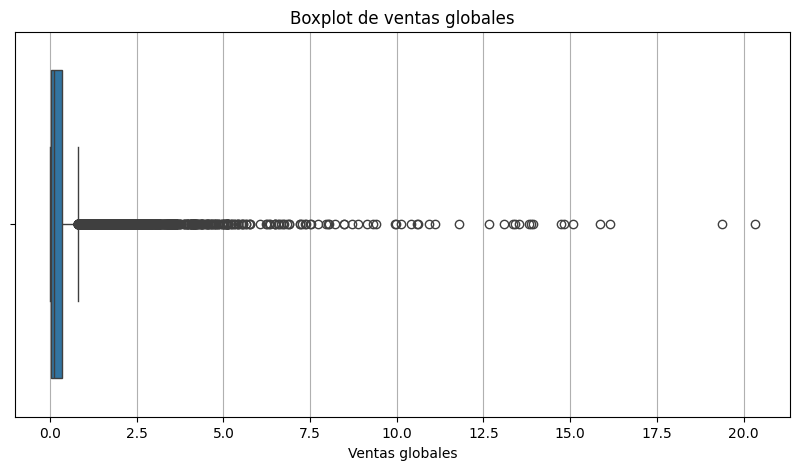

In [9]:
df = pd.read_csv(RAW_PATH)
# 1. Dimensiones, columnas y tipos
print("Dimensiones del dataset:", df.shape)

print("\nPrimeras filas del dataset:")
display(df.head())

print("\nTipos de datos detectados inicialmente:")
display(df.dtypes)

# 2. Valores nulos (absolutos y porcentuales)
nulos_abs = df.isna().sum()
nulos_pct = (df.isna().sum() / len(df)) * 100

print("\nValores nulos absolutos:")
display(nulos_abs)

print("\nValores nulos en porcentaje:")
display(nulos_pct.round(2))

# 3. Duplicados
duplicados = df.duplicated().sum()
print("\nNúmero de filas duplicadas:", duplicados)

# 4. Estadísticos descriptivos (solo numéricos válidos)
print("\nDescripción estadística de variables numéricas detectadas:")
display(df.select_dtypes(include=["number"]).describe())

# 5. Distribución de variables categóricas principales
print("\nTop géneros:")
display(df["genre"].value_counts().head(10))

print("\nTop consolas:")
display(df["console"].value_counts().head(10))

print("\nTop publishers:")
display(df["publisher"].value_counts().head(10))

print("\nTop developers:")
display(df["developer"].value_counts().head(10))

# 6. Detectar outliers de ventas globales (aunque aún no estén limpias)
plt.figure(figsize=(10,5))
sns.boxplot(x=df["total_sales"])
plt.title("Boxplot de ventas globales")
plt.xlabel("Ventas globales")
plt.show()


### 1.3 Limpieza y normalización del dataset

En esta sección se aplica un proceso de limpieza exhaustivo siguiendo las directrices del enunciado: corrección de tipos de datos, tratamiento de valores nulos, eliminación de duplicados, normalización de categorías y resolución de incoherencias. El objetivo es obtener un dataset consistente, coherente y apto para realizar el análisis exploratorio de forma fiable.

La lógica de limpieza se ha encapsulado en una función externa llamada `limpiar_dataset`, definida en el módulo `src/funcion.py`.  
Esta función:

- Lee el archivo original `vgchartz-2024.csv`.
- Aplica todas las transformaciones de limpieza.
- Genera un nuevo archivo `vgchartz-2024-clean.csv` con los datos ya depurados.
- Devuelve un `DataFrame` limpio que se utilizará en las siguientes secciones del cuaderno.

A continuación se detallan los pasos principales que realiza la función.

---

#### 1. Conversión de tipos de datos

Se convierten a formato numérico todas las columnas relacionadas con ventas (`na_sales`, `pal_sales`, `jp_sales`, `other_sales`, `total_sales`).  
Esto permite operar sobre ellas correctamente y detectar valores no válidos, que pasan a ser `NaN` mediante `errors="coerce"`.

También se convierten a tipo fecha (`datetime`) las columnas:

- `release_date`
- `last_update`

y se asegura que la puntuación crítica (`critic_score`) es numérica.

Esta etapa es esencial para detectar errores en el formato original y preparar las variables para su análisis posterior.

---

#### 2. Tratamiento de valores nulos

**2.1 Eliminación de filas sin ventas globales**

Las filas sin `total_sales` no aportan información útil para un análisis centrado en ventas y pueden generar problemas en cálculos agregados.  
Por ello se eliminan estas filas. No se asume que un valor vacío implica cero ventas.

**2.2 Relleno de nulos en columnas categóricas**

Las columnas `developer` y `publisher` representan entidades textuales.  
Cuando estos valores son nulos, se reemplazan por `"Unknown"` para reflejar explícitamente que la información no está disponible. Esto evita problemas al agrupar por estas columnas.

**2.3 Relleno de nulos en `critic_score` con la mediana**

La puntuación crítica es una variable numérica continua.  
En lugar de eliminar filas con este valor faltante, se utiliza la mediana, que es robusta frente a valores extremos y mantiene más registros en el análisis.

**2.4 Relleno de nulos en ventas regionales con 0**

Cuando un juego no presenta ventas registradas en una región (`na`, `pal`, `jp`, `other`), se interpreta como ausencia de ventas.  
Por este motivo, los valores nulos en las columnas de ventas regionales se reemplazan por 0.

---

#### 3. Recalculo de `total_sales` y control de incoherencias

Para asegurar la consistencia interna del dataset, se recalcula `total_sales` como la suma de las cuatro regiones:

- Norteamérica (`na_sales`)
- Europa/PAL (`pal_sales`)
- Japón (`jp_sales`)
- Otras regiones (`other_sales`)

En caso de discrepancias con el valor original, se prioriza la versión recalculada.  
Además, se eliminan registros con:

- Ventas negativas.
- Puntuaciones críticas negativas.

Estos valores se consideran incoherentes con datos reales.

---

#### 4. Eliminación de duplicados

Se eliminan filas duplicadas mediante `drop_duplicates()`.  
Este paso evita duplicar juegos en el análisis y asegura que cada fila represente un único registro.

---

#### 5. Normalización de categorías

Para homogeneizar el formato de las variables categóricas se aplican las siguientes reglas:

- Los géneros (`genre`) se convierten a minúsculas.
- Las consolas (`console`) se normalizan en mayúsculas.
- `publisher` y `developer` se formatean con estilo título (`Title Case`).
- Se eliminan espacios extra mediante `str.strip()`.

Esto evita que la misma categoría aparezca varias veces con formatos ligeramente distintos.

---

#### 6. Comprobación final de calidad

Al finalizar la limpieza, se revisa:

- El número de valores nulos por columna.
- Los tipos de datos resultantes.
- Una vista previa del dataset limpio.

Estas comprobaciones permiten confirmar que las transformaciones se han aplicado correctamente y que el dataset está preparado para el análisis exploratorio.

En el cuaderno, la limpieza se ejecuta llamando a la función `limpiar_dataset`. A continuación se muestra el código utilizado.


In [33]:

# Asegurar que se puede importar desde src/
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import importlib
import src.Limpieza as Limpieza
importlib.reload(Limpieza)
from src.Limpieza import limpiar_dataset

# Llamada a la función de limpieza
df_limpio = limpiar_dataset(RAW_PATH, CLEAN_PATH)

print("\nDimensiones del dataset limpio:", df_limpio.shape)

print("\nResumen final de valores nulos:")
display(df_limpio.isna().sum())

print("\nTipos de datos después de la limpieza:")
display(df_limpio.dtypes)

print("\nVista previa del dataset limpio:")
df_limpio.head()
df = df_limpio

Dimensiones iniciales del dataset crudo: (64016, 14)

Tipos de datos tras conversión inicial:
img                     object
title                   object
console                 object
genre                   object
publisher               object
developer               object
critic_score           float64
total_sales            float64
na_sales               float64
jp_sales               float64
pal_sales              float64
other_sales            float64
release_date    datetime64[ns]
last_update     datetime64[ns]
dtype: object

Filas eliminadas por total_sales nulo: 45094
Filas donde total_sales original difiere de la suma de regiones: 6826
Duplicados eliminados: 0

Resumen final de valores nulos:
img                 0
title               0
console             0
genre               0
publisher           0
developer           0
critic_score        0
total_sales         0
na_sales            0
jp_sales            0
pal_sales           0
other_sales         0
release_date       9

img                 0
title               0
console             0
genre               0
publisher           0
developer           0
critic_score        0
total_sales         0
na_sales            0
jp_sales            0
pal_sales           0
other_sales         0
release_date       90
last_update     14903
dtype: int64


Tipos de datos después de la limpieza:


img                     object
title                   object
console                 object
genre                   object
publisher               object
developer               object
critic_score           float64
total_sales            float64
na_sales               float64
jp_sales               float64
pal_sales              float64
other_sales            float64
release_date    datetime64[ns]
last_update     datetime64[ns]
dtype: object


Vista previa del dataset limpio:


# 2 Visualizaciones básicas

En esta sección se presentan distintas vistas que ayudan a comprender el comportamiento del mercado del videojuego a partir del dataset limpio.  
Cada visualización responde a una pregunta concreta y refuerza las conclusiones del análisis exploratorio.

---

### Vista 1: Histograma de ventas globales (`total_sales`)

El objetivo de esta visualización es analizar la distribución de las ventas globales de los videojuegos.  
Se representa un histograma de `total_sales` con una curva de densidad para observar la forma de la distribución.

Esta vista permite ver si la mayoría de títulos venden poco y si existe un grupo reducido de superventas. La distribución es claramente asimétrica, con una “cola larga” típica de este tipo de mercado, donde pocos juegos concentran gran parte de las ventas totales.

---

### Vista 2: Frecuencia de géneros por número de juegos

Aquí se representa un gráfico de barras con los 10 géneros más frecuentes según el número de juegos disponibles en el catálogo.  
El objetivo es entender qué tipos de juegos se publican con mayor frecuencia.

Esta vista no mide ventas, sino cantidad de títulos. Permite comprobar qué géneros son más comunes en la oferta de videojuegos y cuáles tienen menos presencia en el mercado.

---

### Vista 3: Número de juegos por distribuidora (`publisher`)

En esta vista se muestra una tabla con las compañías distribuidoras que tienen más juegos en el dataset, ordenadas por número de títulos.  
El objetivo es identificar qué empresas publican más videojuegos.

Esta información ayuda a detectar qué publishers tienen un catálogo más amplio y, por tanto, mayor presencia en el mercado, independientemente del volumen de ventas.

---

### Vista 4: Juegos donde desarrollador y distribuidora son distintos

Esta vista filtra los juegos en los que `developer` y `publisher` no coinciden y muestra los casos más relevantes ordenados por ventas globales.  
El objetivo es observar ejemplos en los que el estudio que desarrolla el juego no es el mismo que lo distribuye.

Permite entender la colaboración entre estudios y distribuidoras, y ver qué combinaciones han tenido más éxito en ventas.

---

### Vista 6: Top 20 juegos más vendidos

En esta tabla se muestran los 20 juegos con mayores ventas globales, incluyendo título, consola, género, distribuidora y ventas totales.  
El objetivo es identificar los títulos más exitosos del dataset.

Esta vista confirma la fuerte concentración del mercado: un número reducido de juegos acumula una gran parte de las ventas globales.

---

### Vista 7: Top 10 consolas por ventas globales

Esta vista agrupa las ventas por consola y muestra las 10 plataformas con mayor volumen de ventas acumuladas.  
El objetivo es conocer qué consolas han tenido mayor impacto comercial.

La tabla permite comparar de forma rápida qué plataformas concentran más ventas y situarlas en el contexto general del mercado.

---

### Vista 8: Ventas globales por género (top 10)

Aquí se agrupan las ventas globales por género y se muestran los 10 géneros con mayores ventas totales.  
El objetivo es analizar qué tipos de juegos generan más ingresos, no solo cuántos títulos existen.

Esta vista complementa la frecuencia de géneros con una perspectiva de rendimiento económico.

---

### Vista 9: Matriz de correlación entre ventas regionales y ventas globales

En esta vista se calcula la matriz de correlación entre las columnas de ventas por región (`na_sales`, `pal_sales`, `jp_sales`, `other_sales`) y las ventas globales (`total_sales`).  
El objetivo es medir qué regiones están más relacionadas con el resultado global.

La matriz permite ver qué mercados tienen más peso en las ventas totales y qué regiones están más alineadas entre sí.

---

### Vista 10: Ventas globales por año

Esta vista agrupa las ventas por año de lanzamiento y muestra el total de ventas globales por año.  
El objetivo es analizar la evolución temporal del mercado.

La tabla permite detectar picos de ventas, periodos de crecimiento y posibles etapas de descenso, asociados a ciclos de consolas o cambios en la industria.

---

### Vista 11: Juego más vendido por distribuidora (`publisher`)

Aquí se identifica, para cada distribuidora, el juego con mayores ventas globales.  
El objetivo es ver cuál es el título más representativo o exitoso de cada compañía.

Esta vista permite relacionar cada publisher con su “juego estrella” y comparar el impacto de esos títulos en el mercado.

---

### Vista 12: Juego más vendido por año

En esta vista se selecciona, para cada año, el juego con mayores ventas globales.  
El objetivo es ver qué título lidera cada periodo y cómo cambia el tipo de juego dominante a lo largo del tiempo.

Esta tabla ayuda a entender qué juegos han marcado cada año en cuanto a ventas.

---

### Vista 13: Top 20 juegos mejor valorados por la crítica

Esta vista ordena los juegos según `critic_score` y muestra los 20 mejor valorados, junto con consola, género, distribuidora y desarrolladora.  
El objetivo es identificar los títulos con mejor valoración crítica.

Esta información permite comparar más adelante si estos juegos coinciden o no con los más vendidos.

---

### Vista 14: Distribuidoras mejor valoradas (media de `critic_score`)

En esta vista se calcula, para cada distribuidora, la media de `critic_score` y el número de juegos que tiene en el dataset.  
Se filtran solo las compañías con un mínimo de títulos y se muestra el top ordenado por puntuación media.

El objetivo es identificar las distribuidoras que, de forma consistente, publican juegos bien valorados por la crítica.

---

### Vista 15: Top 20 desarrolladoras por ventas globales

Esta vista agrupa las ventas globales por desarrolladora (`developer`) y muestra las 20 que acumulan mayor volumen.  
El objetivo es detectar los estudios con más impacto económico.

La tabla permite identificar qué desarrolladoras han generado más ventas en el conjunto del catálogo.

---

### Vista 16: Género con mayores ventas por región

En esta vista se analiza, para cada región de ventas, qué género acumula el mayor volumen de ventas.  
El objetivo es entender qué tipo de juego domina en cada zona: Norteamérica, Europa (PAL), Japón y otras regiones.

Permite observar diferencias claras en las preferencias según la región, comparando qué géneros funcionan mejor en cada mercado.

---

### Vista 17: Estudio con mayores ventas por región

Esta vista es similar a la anterior, pero agrupando por desarrolladora en lugar de por género.  
Para cada región se identifica el estudio que más vende en ese territorio.

El objetivo es ver qué desarrolladoras son más fuertes en cada mercado y cómo cambia el liderazgo según la zona geográfica.

---

### Vista 18: Top 20 desarrolladoras por número de juegos (sin “Unknown”)

En esta vista se filtran las filas para excluir desarrolladoras desconocidas y se cuenta el número de juegos por estudio.  
Se representan los 20 estudios con más títulos mediante un gráfico de barras.

El objetivo es analizar qué desarrolladoras tienen un catálogo más amplio y están más presentes en el dataset.

---

### Vista 19: Juego más vendido por género

Esta vista identifica, para cada género, el juego con mayores ventas globales.  
El objetivo es encontrar qué título representa mejor a cada género desde el punto de vista comercial.

Permite relacionar cada categoría con su juego más exitoso.

---

### Vista 20: Juego más vendido por consola

En esta vista se ordenan los juegos por ventas globales y se selecciona el título más vendido de cada consola.  
El objetivo es saber cuál es el juego más representativo de cada plataforma en términos de ventas.

La tabla facilita comparar el “juego estrella” de cada consola.

---

### Vista 21: Estudio más presente por consola (sin “Unknown”)

Aquí se filtran las filas con desarrolladora conocida y se cuenta el número de juegos por combinación de consola y estudio.  
Para cada consola se selecciona el desarrollador con más títulos.

El objetivo es ver qué estudios están más asociados a cada plataforma y cuáles han trabajado más en cada sistema.

---

### Vista 22: Porcentaje anual de ventas por región

En esta vista se calculan las ventas por año y región, y se convierten en porcentajes sobre el total de ese año.  
El resultado se muestra en una tabla con los porcentajes formateados.

El objetivo es analizar cómo cambia el peso relativo de cada región a lo largo del tiempo, independientemente del volumen total de ventas de cada año.

---

### Vista 23: Relación entre ventas en Norteamérica y ventas globales

Esta visualización representa un diagrama de dispersión entre `na_sales` y `total_sales`, acompañado de una recta de regresión.  
El objetivo es estudiar la relación entre las ventas en Norteamérica y las ventas globales.

La gráfica permite ver si un buen desempeño en Norteamérica suele asociarse a buenas ventas globales y detectar posibles excepciones donde el éxito esté más concentrado en otras regiones.


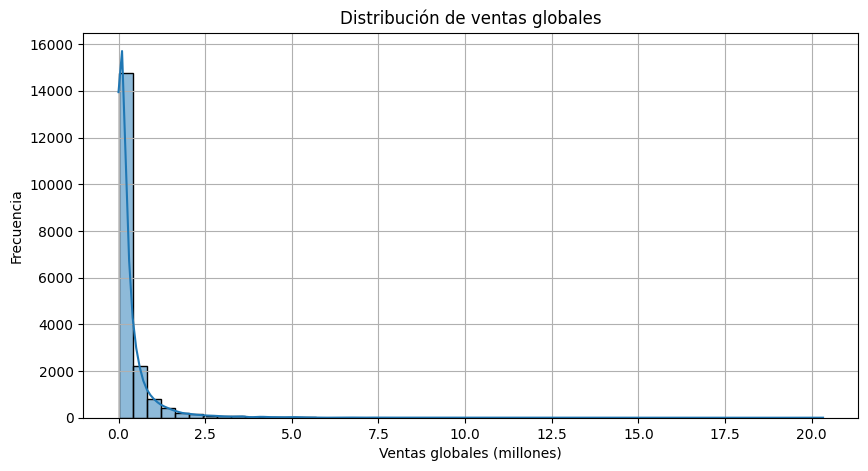


Interpretación:
- La mayoría de los videojuegos registran ventas bajas.
- Un número reducido de títulos concentra ventas muy altas.
- La distribución es muy asimétrica, típica del mercado del videojuego.



In [34]:
#Vista 1
plt.figure(figsize=(10,5))
sns.histplot(df["total_sales"], kde=True, bins=50)
plt.title("Distribución de ventas globales")
plt.xlabel("Ventas globales (millones)")
plt.ylabel("Frecuencia")
plt.show()

print("""
Interpretación:
- La mayoría de los videojuegos registran ventas bajas.
- Un número reducido de títulos concentra ventas muy altas.
- La distribución es muy asimétrica, típica del mercado del videojuego.
""")

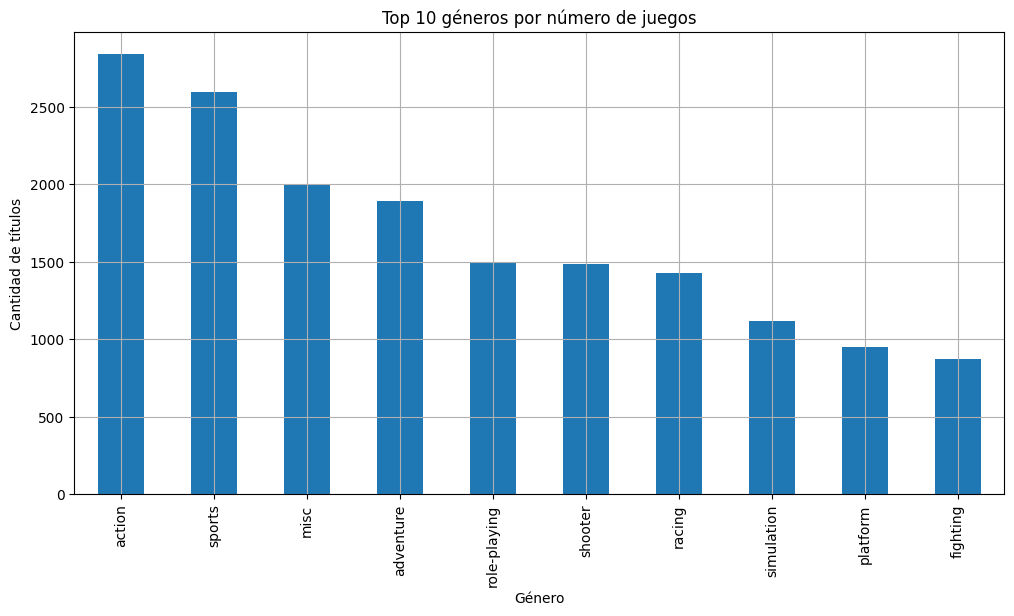


Interpretación:
- Muestra qué géneros son más frecuentes en el catálogo.
- NO implica más ventas, solo mayor cantidad de juegos publicados.



In [35]:
#Vista 2
plt.figure(figsize=(12,6))
df["genre"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 géneros por número de juegos")
plt.xlabel("Género")
plt.ylabel("Cantidad de títulos")
plt.show()

print("""
Interpretación:
- Muestra qué géneros son más frecuentes en el catálogo.
- NO implica más ventas, solo mayor cantidad de juegos publicados.
""")

In [36]:
#Vista 3
# Contar número de juegos por compañía (publisher)
vista3_publishers = (
    df.groupby("publisher")["title"]
      .count()
      .sort_values(ascending=False)
      .reset_index()
      .rename(columns={"title": "num_juegos"})
)

# Mostrar las 20 compañías con más juegos
vista3_publishers.head(20)


,publisher,num_juegos
0,Activision,1044
1,Ubisoft,1012
2,Electronic Arts,843
3,Konami,769
4,Thq,726
5,Sega,641
6,Sony Computer Entertainment,568
7,Ea Sports,540
8,Capcom,437
9,Nintendo,384


In [37]:
#Vista 4
# Filtrar juegos donde developer y publisher son distintos
vista4_diff_dev_pub = df[df["developer"] != df["publisher"]].copy()

# Ordenar por ventas globales para ver los ejemplos más relevantes
vista4_diff_dev_pub = vista4_diff_dev_pub.sort_values("total_sales", ascending=False)

# Mostrar los 20 principales ejemplos
vista4_diff_dev_pub[["title", "console", "genre", "developer", "publisher", "total_sales"]].head(20)


,title,console,genre,developer,publisher,total_sales
0,Grand Theft Auto V,PS3,action,Rockstar North,Rockstar Games,20.33
1,Grand Theft Auto V,PS4,action,Rockstar North,Rockstar Games,19.39
2,Grand Theft Auto: Vice City,PS2,action,Rockstar North,Rockstar Games,16.15
3,Grand Theft Auto V,X360,action,Rockstar North,Rockstar Games,15.87
4,Call of Duty: Black Ops 3,PS4,shooter,Treyarch,Activision,15.08
5,Call of Duty: Modern Warfare 3,X360,shooter,Infinity Ward,Activision,14.82
6,Call of Duty: Black Ops,X360,shooter,Treyarch,Activision,14.74
8,Call of Duty: Black Ops II,X360,shooter,Treyarch,Activision,13.86
9,Call of Duty: Black Ops II,PS3,shooter,Treyarch,Activision,13.80
10,Call of Duty: Modern Warfare 2,X360,shooter,Infinity Ward,Activision,13.53


In [ ]:
### Vista 5: % en distintas areas de los videojuegos

In [38]:
#Vista 6
vista6_top20_juegos = (
    df.sort_values("total_sales", ascending=False)
      .head(20)
      [["title", "console", "genre", "publisher", "total_sales"]]
)

vista6_top20_juegos


,title,console,genre,publisher,total_sales
0,Grand Theft Auto V,PS3,action,Rockstar Games,20.33
1,Grand Theft Auto V,PS4,action,Rockstar Games,19.39
2,Grand Theft Auto: Vice City,PS2,action,Rockstar Games,16.15
3,Grand Theft Auto V,X360,action,Rockstar Games,15.87
4,Call of Duty: Black Ops 3,PS4,shooter,Activision,15.08
5,Call of Duty: Modern Warfare 3,X360,shooter,Activision,14.82
6,Call of Duty: Black Ops,X360,shooter,Activision,14.74
7,Red Dead Redemption 2,PS4,action-adventure,Rockstar Games,13.94
8,Call of Duty: Black Ops II,X360,shooter,Activision,13.86
9,Call of Duty: Black Ops II,PS3,shooter,Activision,13.80


In [39]:
#Vista 7
vista7_consolas = (
    df.groupby("console")["total_sales"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .reset_index()
      .rename(columns={"total_sales": "ventas_globales"})
)

vista7_consolas


,console,ventas_globales
0,PS2,1027.90
1,X360,859.80
2,PS3,839.93
3,PS,546.41
4,PS4,539.82
5,WII,458.83
6,DS,457.25
7,XONE,268.88
8,PSP,245.23
9,XB,231.50


In [40]:
#Vista 8
vista8_generos = (
    df.groupby("genre")["total_sales"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .reset_index()
      .rename(columns={"total_sales": "ventas_globales"})
)

vista8_generos


,genre,ventas_globales
0,sports,1186.85
1,action,1124.92
2,shooter,995.43
3,misc,557.13
4,racing,525.53
5,role-playing,427.00
6,platform,348.81
7,fighting,341.06
8,adventure,325.00
9,simulation,300.02


In [41]:
#Vista 9
columnas_ventas = ["na_sales", "pal_sales", "jp_sales", "other_sales", "total_sales"]
vista9_corr = df[columnas_ventas].corr()
vista9_corr


,na_sales,pal_sales,jp_sales,other_sales,total_sales
na_sales,1.000000,0.696569,0.033254,0.694877,0.912257
pal_sales,0.696569,1.000000,0.101892,0.821970,0.905068
jp_sales,0.033254,0.101892,1.000000,0.117758,0.214409
other_sales,0.694877,0.821970,0.117758,1.000000,0.858733
total_sales,0.912257,0.905068,0.214409,0.858733,1.000000


In [42]:
#Vista 10
# Asegurarse de que release_date está en datetime
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")

df_year = df.dropna(subset=["release_date"]).copy()
df_year["year"] = df_year["release_date"].dt.year

vista10_ventas_por_año = (
    df_year.groupby("year")["total_sales"]
           .sum()
           .reset_index()
           .sort_values("year")
           .rename(columns={"total_sales": "ventas_globales"})
)

vista10_ventas_por_año


,year,ventas_globales
0,1977,2.50
1,1978,2.34
2,1979,0.31
3,1980,2.26
4,1981,7.74
5,1982,28.92
6,1983,22.68
7,1984,4.86
8,1985,2.19
9,1986,10.35


In [43]:
#Vista 11
# Obtener índice del juego con más ventas por publisher
idx_max_por_publisher = df.groupby("publisher")["total_sales"].idxmax()

vista10b_top_juego_por_publisher = df.loc[idx_max_por_publisher, ["publisher", "title", "console", "genre", "total_sales"]]
vista10b_top_juego_por_publisher.sort_values("total_sales", ascending=False).head(30)


,publisher,title,console,genre,total_sales
0,Rockstar Games,Grand Theft Auto V,PS3,action,20.33
4,Activision,Call of Duty: Black Ops 3,PS4,shooter,15.08
15,Ea Sports,FIFA 18,PS4,sports,11.79
17,Electronic Arts,FIFA 17,PS4,sports,10.94
22,Microsoft Game Studios,Halo: Reach,X360,shooter,9.97
23,Microsoft Studios,Halo 4,X360,shooter,9.95
27,Bethesda Softworks,The Elder Scrolls V: Skyrim,X360,role-playing,8.88
44,Ubisoft,Just Dance 4,WII,music,6.88
46,Sony Computer Entertainment,Uncharted 2: Among Thieves,PS3,action,6.73
56,Gt Interactive,Driver,PS,action,6.26


In [44]:
#Vista 12
# Asegurarnos de tener la columna de año
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df_year = df.dropna(subset=["release_date"]).copy()
df_year["year"] = df_year["release_date"].dt.year

idx_max_por_año = df_year.groupby("year")["total_sales"].idxmax()

vista11_top_juego_por_año = df_year.loc[idx_max_por_año, ["year", "title", "console", "genre", "total_sales"]]
vista11_top_juego_por_año.sort_values("year")


,year,title,console,genre,total_sales
1102,1977,Combat,2600,action,1.25
3653,1978,Circus Atari,2600,action,0.46
5175,1979,Slot Machine,2600,action,0.31
2059,1980,Boxing,2600,fighting,0.77
125,1981,Asteroids,2600,shooter,4.31
467,1982,Demon Attack,2600,shooter,2.13
719,1983,Dig Dug,2600,puzzle,1.64
2037,1984,Jr. Pac-Man,2600,puzzle,0.78
1918,1985,Clu Clu Land,NES,puzzle,0.82
815,1986,Ninja Hattori Kun: Ninja wa Shuugyou Degogiru ...,NES,platform,1.50


In [45]:
#Vista 13
vista12_mejor_valorados = (
    df.sort_values("critic_score", ascending=False)
      .head(20)
      [["title", "console", "genre", "publisher", "developer", "critic_score"]]
)

vista12_mejor_valorados


,title,console,genre,publisher,developer,critic_score
16,Grand Theft Auto IV,X360,action,Rockstar Games,Rockstar North,10.0
1191,Red Dead Redemption: Undead Nightmare,PS3,action,Rockstar Games,Rockstar San Diego,10.0
19,Grand Theft Auto IV,PS3,action,Rockstar Games,Rockstar North,10.0
1290,Red Dead Redemption: Undead Nightmare,X360,action,Rockstar Games,Rockstar San Diego,10.0
357,Rockstar Games Double Pack: Grand Theft Auto I...,XB,action,Rockstar Games,Rockstar North,9.8
7,Red Dead Redemption 2,PS4,action-adventure,Rockstar Games,Rockstar Games,9.8
657,Rockstar Games Double Pack: Grand Theft Auto I...,PS2,action,Rockstar Games,Rockstar North,9.7
1,Grand Theft Auto V,PS4,action,Rockstar Games,Rockstar North,9.7
8520,The Orange Box,PC,shooter,Electronic Arts,Valve Software,9.7
603,The Orange Box,X360,shooter,Electronic Arts,Valve Software,9.7


In [46]:
#Vista 14
# Media de critic_score y recuento de juegos por publisher
stats_publisher = df.groupby("publisher")["critic_score"].agg(["mean", "count"]).reset_index()

# Filtrar compañías con un mínimo de juegos 
stats_publisher_filtrado = stats_publisher[stats_publisher["count"] >= 5]

# Ordenar por media de puntuación
vista13_top_publishers_valorados = stats_publisher_filtrado.sort_values("mean", ascending=False).head(20)
vista13_top_publishers_valorados.rename(columns={"mean": "critic_score_medio", "count": "num_juegos"}, inplace=True)

vista13_top_publishers_valorados


,publisher,critic_score_medio,num_juegos
542,Redoctane,8.337500,8
552,Rockstar Games,8.003226,93
97,Blizzard Entertainment,7.975000,12
408,Microprose,7.940000,5
430,Mtv Games,7.845455,44
442,Ncsoft,7.720000,5
212,Fox Interactive,7.681818,11
240,Gathering Of Developers,7.673684,19
452,Nicalis,7.611111,9
400,Merge Games,7.550000,8


In [47]:
#Vista 15
vista14_top_devs_ventas = (
    df.groupby("developer")["total_sales"]
      .sum()
      .sort_values(ascending=False)
      .head(20)
      .reset_index()
      .rename(columns={"total_sales": "ventas_globales"})
)

vista14_top_devs_ventas


,developer,ventas_globales
0,Ea Canada,275.50
1,Ea Tiburon,178.43
2,Ubisoft Montreal,172.94
3,Treyarch,150.15
4,Traveller'S Tales,149.65
5,Infinity Ward,119.00
6,Rockstar North,116.90
7,Konami,109.60
8,Visual Concepts,97.52
9,Capcom,92.83


In [48]:
#Vista 16
# Diccionario para traducir los nombres de columnas a nombres legibles
region_labels = {
    "na_sales": "Norteamérica",
    "pal_sales": "Europa (PAL)",
    "jp_sales": "Japón",
    "other_sales": "Otras regiones"
}

resultados_dev = []

for col_region, nombre_region in region_labels.items():
    ventas_por_gen = df.groupby("genre")[col_region].sum()
    top_dev = ventas_por_gen.idxmax()
    ventas_top = ventas_por_gen.max()
    resultados_dev.append({
        "zona_ventas": nombre_region,
        "top_developer": top_dev,
        "ventas_region_millones": ventas_top
    })

vista16_top_dev_por_region = pd.DataFrame(resultados_dev)
vista16_top_dev_por_region


,zona_ventas,top_developer,ventas_region_millones
0,Norteamérica,sports,607.47
1,Europa (PAL),action,342.52
2,Japón,role-playing,130.56
3,Otras regiones,sports,128.19


In [49]:
#Vista 17
# Diccionario para traducir los nombres de columnas a nombres legibles
region_labels = {
    "na_sales": "Norteamérica",
    "pal_sales": "Europa (PAL)",
    "jp_sales": "Japón",
    "other_sales": "Otras regiones"
}

resultados_dev = []

for col_region, nombre_region in region_labels.items():
    ventas_por_dev = df.groupby("developer")[col_region].sum()
    top_dev = ventas_por_dev.idxmax()
    ventas_top = ventas_por_dev.max()
    resultados_dev.append({
        "zona_ventas": nombre_region,
        "top_developer": top_dev,
        "ventas_region_millones": ventas_top
    })

vista16_top_dev_por_region = pd.DataFrame(resultados_dev)
vista16_top_dev_por_region


,zona_ventas,top_developer,ventas_region_millones
0,Norteamérica,Ea Tiburon,141.34
1,Europa (PAL),Ea Canada,131.12
2,Japón,Konami,39.70
3,Otras regiones,Ea Canada,38.40


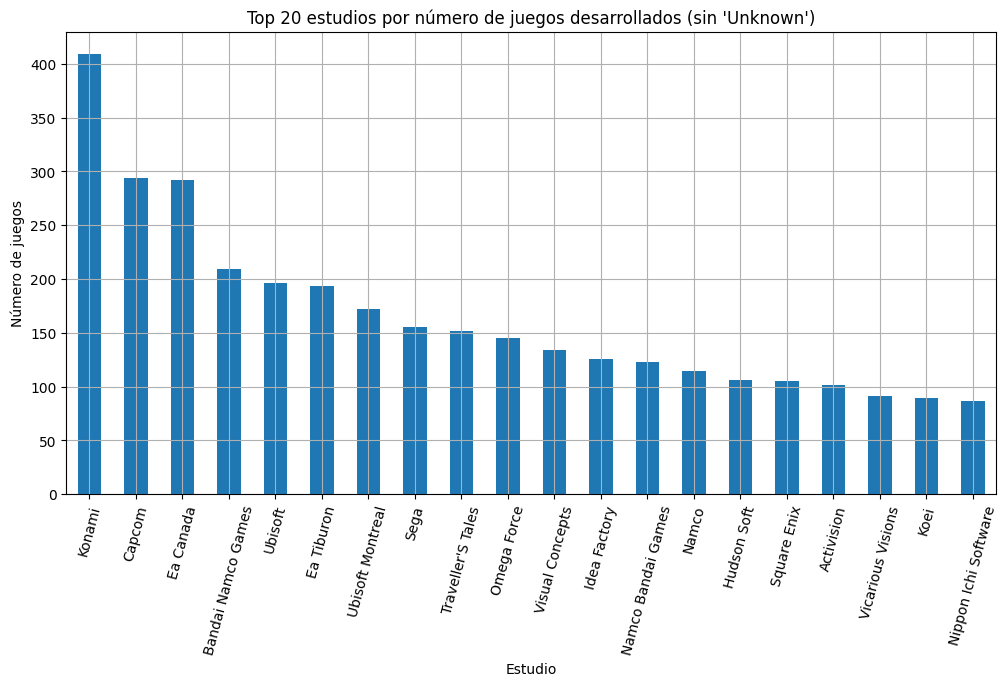

In [50]:
#Vista 18
# Filtrar filas donde el developer no sea "Unknown"
df_dev_known = df[df["developer"] != "Unknown"].copy()

# Contar número de juegos por estudio 
juegos_por_dev = (
    df_dev_known.groupby("developer")["title"]
                .count()
                .sort_values(ascending=False)
                .head(20)
)

plt.figure(figsize=(12,6))
juegos_por_dev.plot(kind="bar")
plt.title("Top 20 estudios por número de juegos desarrollados (sin 'Unknown')")
plt.xlabel("Estudio")
plt.ylabel("Número de juegos")
plt.xticks(rotation=75)
plt.show()



In [51]:
#Vista 19
idx_max_por_genero = df.groupby("genre")["total_sales"].idxmax()

vista18_top_juego_por_genero = df.loc[idx_max_por_genero, ["genre", "title", "console", "total_sales"]]
vista18_top_juego_por_genero.sort_values("total_sales", ascending=False)


,genre,title,console,total_sales
0,action,Grand Theft Auto V,PS3,20.33
4,shooter,Call of Duty: Black Ops 3,PS4,15.08
7,action-adventure,Red Dead Redemption 2,PS4,13.94
15,sports,FIFA 18,PS4,11.79
27,role-playing,The Elder Scrolls V: Skyrim,X360,8.88
34,simulation,The Sims 3,PC,7.97
42,racing,Need for Speed Underground,PS2,7.20
44,music,Just Dance 4,WII,6.88
54,misc,Minecraft,PS4,6.33
61,fighting,Tekken 2,PS,5.74


In [52]:
#Vista 20
# Quitamos filas sin total_sales
df_valid_sales = df.dropna(subset=["total_sales"]).copy()

# Ordenamos por ventas globales de mayor a menor
df_ordenado = df_valid_sales.sort_values("total_sales", ascending=False)

# Para cada consola, nos quedamos con la primera fila
vista19_top_juego_por_consola = (
    df_ordenado
    .drop_duplicates(subset="console", keep="first")
    [["console", "title", "genre", "total_sales"]]
    .sort_values("total_sales", ascending=False)
)

vista19_top_juego_por_consola



,console,title,genre,total_sales
0,PS3,Grand Theft Auto V,action,20.33
1,PS4,Grand Theft Auto V,action,19.39
2,PS2,Grand Theft Auto: Vice City,action,16.15
3,X360,Grand Theft Auto V,action,15.87
28,XONE,Grand Theft Auto V,action,8.72
34,PC,The Sims 3,simulation,7.97
35,PSP,Grand Theft Auto: Liberty City Stories,action,7.71
44,WII,Just Dance 4,music,6.88
56,PS,Driver,action,6.26
63,DS,Cooking Mama,simulation,5.66


In [53]:
#Vista 21
# Filtramos para quedarnos solo con estudios conocidos
df_known_dev = df[df["developer"] != "Unknown"].copy()

# Conteo de juegos por consola y estudio
conteo_consola_dev = (
    df_known_dev.groupby(["console", "developer"])["title"]
                .count()
                .reset_index()
                .rename(columns={"title": "num_juegos"})
)

# Para cada consola, coger el estudio con más juegos
idx_max_por_consola = conteo_consola_dev.groupby("console")["num_juegos"].idxmax()

vista21_dev_mas_presente_por_consola = conteo_consola_dev.loc[idx_max_por_consola]
vista21_dev_mas_presente_por_consola.sort_values("num_juegos", ascending=False)



,console,developer,num_juegos
663,DS,Konami,86
3449,PS2,Konami,60
4908,PSP,Konami,45
3,2600,Atari,45
60,3DS,Bandai Namco Games,44
6302,X360,Ea Canada,42
2370,PC,Maxis,42
1251,GBA,Konami,39
3885,PS3,Ea Canada,35
2864,PS,Konami,35


In [54]:
#Vista 22
# Asegurarnos de tener el año
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df_year = df.dropna(subset=["release_date"]).copy()
df_year["year"] = df_year["release_date"].dt.year

regiones = ["na_sales", "pal_sales", "jp_sales", "other_sales"]

# Sumar ventas por año y región
ventas_por_año_region = df_year.groupby("year")[regiones].sum()

# Calcular porcentaje por fila (año)
ventas_por_año_region_pct = (
    ventas_por_año_region
    .div(ventas_por_año_region.sum(axis=1), axis=0)
    * 100
)

# Pasar a tabla y renombrar columnas con nombres legibles
tabla_pct = (
    ventas_por_año_region_pct
    .reset_index()
    .rename(columns={
        "year": "Año",
        "na_sales": "Norteamérica",
        "pal_sales": "Europa (PAL)",
        "jp_sales": "Japón",
        "other_sales": "Otras regiones"
    })
)

# Formatear porcentajes a 1 decimal y añadir el símbolo %
for col in ["Norteamérica", "Europa (PAL)", "Japón", "Otras regiones"]:
    tabla_pct[col] = tabla_pct[col].round(1).astype(str) + " %"

tabla_pct




,Año,Norteamérica,Europa (PAL),Japón,Otras regiones
0,1977,93.6 %,5.6 %,0.0 %,0.8 %
1,1978,94.0 %,6.0 %,0.0 %,0.0 %
2,1979,93.5 %,6.5 %,0.0 %,0.0 %
3,1980,93.4 %,5.8 %,0.0 %,0.9 %
4,1981,93.2 %,5.8 %,0.0 %,1.0 %
5,1982,93.6 %,5.5 %,0.0 %,0.9 %
6,1983,93.3 %,5.7 %,0.0 %,1.1 %
7,1984,80.0 %,4.9 %,14.2 %,0.8 %
8,1985,38.4 %,5.9 %,54.8 %,0.9 %
9,1986,16.0 %,3.5 %,80.3 %,0.2 %


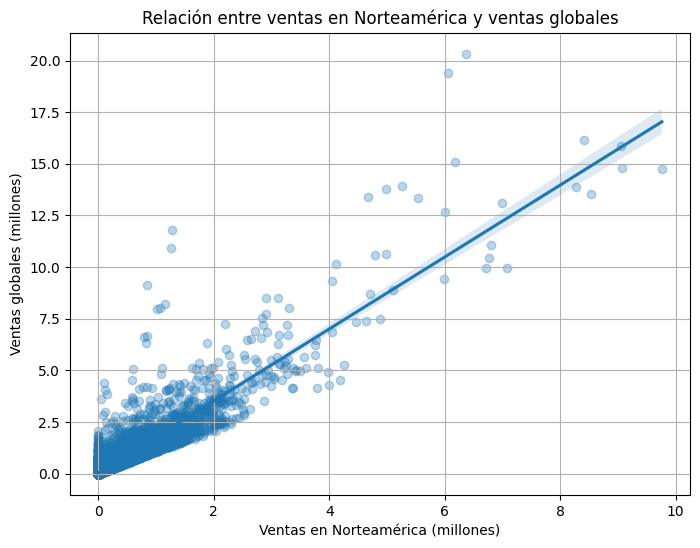


Interpretación:
- Existe relación positiva: cuanto más vende un juego en Norteamérica,
  más probable es que tenga buenas ventas globales.
- No obstante, hay títulos que destacan más en otras regiones.



In [55]:
#Vista 23
plt.figure(figsize=(8,6))
sns.regplot(x=df["na_sales"], y=df["total_sales"], scatter_kws={"alpha":0.3})
plt.title("Relación entre ventas en Norteamérica y ventas globales")
plt.xlabel("Ventas en Norteamérica (millones)")
plt.ylabel("Ventas globales (millones)")
plt.show()

print("""
Interpretación:
- Existe relación positiva: cuanto más vende un juego en Norteamérica,
  más probable es que tenga buenas ventas globales.
- No obstante, hay títulos que destacan más en otras regiones.
""")
